<a href="https://colab.research.google.com/github/tamer017/ML-Assessments/blob/master/Conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **In this notebook we apply different clustering techniques on Multi Blob Data Set, iris data set, and Customer data set and compare the results to find the best technique for each data set.**

Running this project require the following imports



In [1]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.spatial.distance import cdist
# StandardScaler is a function to normalize the data 
# You may also check MinMaxScaler and MaxAbsScaler 
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import normaltest, zscore
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from operator import itemgetter
%matplotlib inline

In [2]:
plt.figure(figsize=(16,8))
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X, method = [], num_clusters = 0,kmean = False):
    # color = ["blue","orange","green","red","purple","brown","pink","gray","olive","cyan","yellow","black","lime","magenta"]  #List colors
    alpha = 0.5  #color obaque
    s = 20
    if num_clusters == 0:
      sns.scatterplot(X[:, 0], X[:, 1], hue=np.zeros((X.shape[0],)), legend='full',palette="Set1")  
    else:
      labels = method.labels_
      if (num_clusters > 45):
        sns.scatterplot(X[:, 0], X[:, 1], hue=labels,palette="Set1").legend_.remove() 
      else: 
        sns.scatterplot(X[:, 0], X[:, 1], hue=labels, legend='auto',palette="Set1")  
        # plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,ncol=3)
      if (kmean):
        for i in range(num_clusters):
            plt.scatter(method.cluster_centers_[i][0], method.cluster_centers_[i][1], c = "black", marker = 'x', s = 100)   
    plt.show()


<Figure size 1152x576 with 0 Axes>

### **Agglomerative clustering**

In [31]:
def Agglomerative_clustering(X, affinities = ['euclidean', 'manhattan', 'cosine'],linkages = ['average', 'single'],distance_thresholds = [3,5,10,1,9,4],no_dendograms = False):
  # Initialize variables to store best results
  best_silhouette_score = -1
  best_params = {}

  # Loop over all parameter combinations and perform clustering
  for affinity in affinities:
      for linkage_method in linkages:
          for distance_threshold in distance_thresholds:
              # Initialize model with current parameters
              model = AgglomerativeClustering(n_clusters=None, 
                                              affinity=affinity, 
                                              linkage=linkage_method,
                                              distance_threshold=distance_threshold)
              model.fit(X)
              n_clusters = np.unique(model.labels_).shape[0]
             
              if (n_clusters > 1):
                # Calculate the silhouette score
                silhouette_avg = silhouette_score(X, model.labels_)
                print("The number of clusters is :",np.unique(model.labels_).shape[0],"clusters",f"with silhouette score : {silhouette_avg:.5f}")
                print(f"Affinity: {affinity}, Linkage: {linkage_method}, Distance Threshold: {distance_threshold}")
                print(f"Silhouette Score: {silhouette_avg:.2f}")
                if(n_clusters <= 20):
                  print(pd.DataFrame(model.labels_).value_counts(normalize = True)*100)
                else:
                  print(pd.DataFrame(model.labels_).value_counts(normalize = True).iloc[:10]*100)
                  print(pd.DataFrame(model.labels_).value_counts(normalize = True).iloc[-10:]*100)

                # If the current score is better than the previous best score, update the variables
                if silhouette_avg > best_silhouette_score:
                    best_silhouette_score = silhouette_avg
                    best_params = {'affinity': affinity, 'linkage': linkage_method, 'distance_threshold': distance_threshold,"nuber of clusters" : n_clusters}
                if X.shape[1] == 2:
                  display_cluster(X, method = model, num_clusters = n_clusters)
                # Plot the dendrogram
                if(no_dendograms == False):
                  linkage_matrix = linkage(model.children_, method=linkage_method)
                  plt.figure(figsize=(12, 5))
                  plt.title(f"Dendrogram ({affinity}, {linkage_method})\nSilhouette Score: {silhouette_avg:.2f}")
                  dendrogram(linkage_matrix,)
                  plt.show()
              else:
                print("distance threshold :",distance_threshold,", linkage methode :",linkage_method,", and affinity :",affinity,"produces only one cluster")
      
              print("-----------------------------------------------------------------------------------------------------")
  return best_silhouette_score, best_params


### **GMM**

In [16]:
def GMM(X,min_clusters = 2, max_clusters = 8, covariance_types = ['spherical', 'tied','diag','full']):
  silhouette_scores = []
  silhouette_scores = []
  n_features = X.shape[1]
  mins = np.min(X, axis=0) - 1
  maxs = np.max(X, axis=0) + 1
  xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100), np.linspace(mins[1], maxs[1], 100))
  mesh_data = np.column_stack((xx.ravel(), yy.ravel()) + (np.zeros((xx.size, n_features - 2)),))
  for covariance_type in covariance_types:
    silhouette_scores_per_covariance_type = []
    for n_clusters in range(min_clusters, max_clusters+1):
      gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state = 0)
      gmm.fit(X)
      labels = gmm.predict(X)
      silhouette_scoree = silhouette_score(X, labels)
      silhouette_scores_per_covariance_type.append(silhouette_scoree)
      print("For", n_clusters, "clusters,", "the average silhouette_score is :", silhouette_scoree, "with covariance type :",covariance_type)
      if(n_clusters <= 10):
        print(pd.DataFrame(labels).value_counts(normalize = True)*100)
      else:
        print(pd.DataFrame(labels).value_counts(normalize = True).iloc[:5]*100)
        print(pd.DataFrame(labels).value_counts(normalize = True).iloc[-5:]*100)      
      if n_features == 2:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))
        Z = gmm.score_samples(mesh_data)
        Z = Z.reshape(xx.shape)
        plt.title('GMM with {} covariance type and {} clusters'.format(covariance_type, n_clusters), fontsize=12)
        axes[0].contourf(xx, yy, Z, levels=10, cmap='viridis',alpha = 0.9)
        sns.scatterplot(X[:, 0], X[:, 1], hue=labels, legend='auto',palette="Set1", ax = axes[1])  
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,ncol=3)
        plt.show()

    silhouette_scores.append(silhouette_scores_per_covariance_type)
  return silhouette_scores[0][0], max_clusters, covariance_type[0]



### **K_mean**

In [6]:
def K_mean(X, min_clusters = 2, max_clusters = 20): 
  distortion_functions = []
  silhouette_scores = []
  inertias = []
  for n_clusters in range(min_clusters, max_clusters+1):
      Kmean = KMeans(n_clusters = n_clusters)
      Kmean.fit(X)
      if X.shape[1] == 2:
        display_cluster(X, method = Kmean, num_clusters = n_clusters,kmean = True)
      distortion_function = sum(np.min(cdist(X, Kmean.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
      inertia = Kmean.inertia_ 
      inertias.append(inertia)
      distortion_functions.append(distortion_function) 
      silhouette_scoree = silhouette_score(X, Kmean.labels_)
      silhouette_scores.append(silhouette_scoree)
      print("For", n_clusters, "clusters,", "the average silhouette_score is :", silhouette_scoree, ", the destortion function is :", distortion_function, ",and inertia is :",inertia)
      print(pd.DataFrame(Kmean.labels_).value_counts(normalize = True)*100)
      plt.show()
  return silhouette_scoree, n_clusters

### **DBScan**

In [32]:
def DBScan(X,min_eps = 0.1, max_eps = 3, min_samples = 5, max_samples = 20):
  eps_values = np.linspace(min_eps, max_eps,int(max_eps/min_eps))
  min_samples_values = np.arange(min_samples, max_samples+1)
  silhouette_scores = np.zeros((len(eps_values), len(min_samples_values)))
  best_silhouette_score = 0
  for i, eps in enumerate(eps_values):
      for j, min_samples in enumerate(min_samples_values):
          dbscan = DBSCAN(eps=eps, min_samples=min_samples)
          dbscan.fit(X)
          n_clusters = len(set(dbscan.labels_))
          if n_clusters > 1:
              silhouette_scores[i][j] = silhouette_score(X, dbscan.labels_)
              print(f"Minimum number of samples : {min_samples:.2f}, and epsilon: {eps:.2f} produces {n_clusters} clusters with silhouette score : {silhouette_scores[i][j]:.5f}")
              try:
                print("The Noise percentage is :", pd.DataFrame(dbscan.labels_).value_counts(normalize = True,sort = False)[-1])
              except:
                print("The Noise percentage is : 0")
              if(n_clusters <= 10):
                print(pd.DataFrame(dbscan.labels_).value_counts(normalize = True)*100)
              else:
                print(pd.DataFrame(dbscan.labels_).value_counts(normalize = True).iloc[:5]*100)
                print(pd.DataFrame(dbscan.labels_).value_counts(normalize = True).iloc[-5:]*100)
              # If the current score is better than the previous best score, update the variables
              if silhouette_scores[i][j] > best_silhouette_score:
                  best_silhouette_score = silhouette_scores[i][j]
                  best_params = {'min_samples': min_samples, 'eps': eps,"n_clusters" : n_clusters}
              if X.shape[1] == 2:
                display_cluster(X, method = dbscan, num_clusters = n_clusters)
          else:
              print(f"Minimum number of samples : {min_samples:.2f}, and epsilon: {eps:.2f} produces only one cluster")
          print("-----------------------------------------------------------------------------------------------------")
  return best_silhouette_score, best_params


## **Multi Blob Data Set**

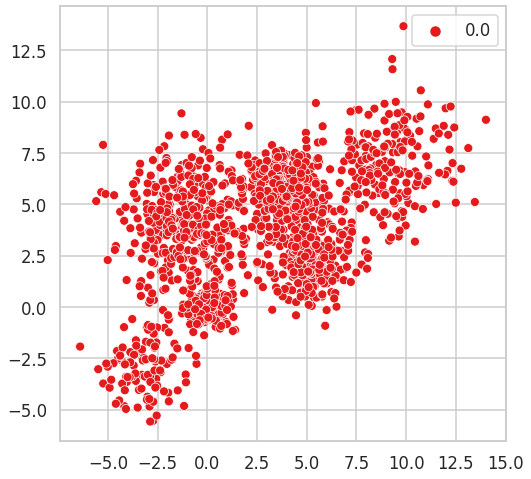

In [3]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
sns.set_context("talk")

n_bins = 6  
centers = [(-3, -3), (0, 0), (5,2.5),(-1, 4), (4, 6), (9,7)]
Multi_blob_Data, y = make_blobs(n_samples=[100,150, 300, 400,300, 200], n_features=2, cluster_std=[1.3,0.6, 1.2, 1.7,0.9,1.7],
                  centers=centers, shuffle=False, random_state=42)
display_cluster(Multi_blob_Data)


===============================================================K_mean==============================================================================


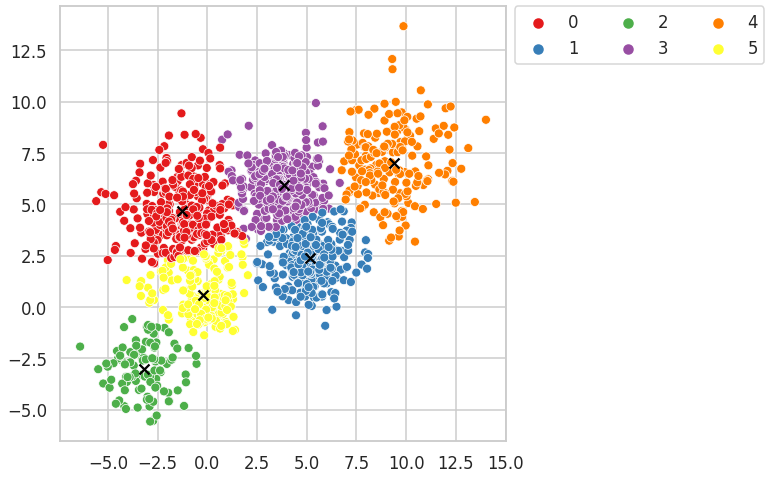

For 6 clusters, the average silhouette_score is : 0.48609408962389006 , the destortion function is : 1.504282169827608 ,and inertia is : 4310.310475305866
3    24.965517
0    20.551724
1    19.172414
5    15.655172
4    12.896552
2     6.758621
dtype: float64
===============================================================DBScan==============================================================================
Minimum number of samples : 10.00, and epsilon: 0.80 produces 4 clusters with silhouette score : 0.25
The Noise percentage is : 0.05517241379310345
 1    78.068966
 2    10.551724
 0     5.862069
-1     5.517241
dtype: float64


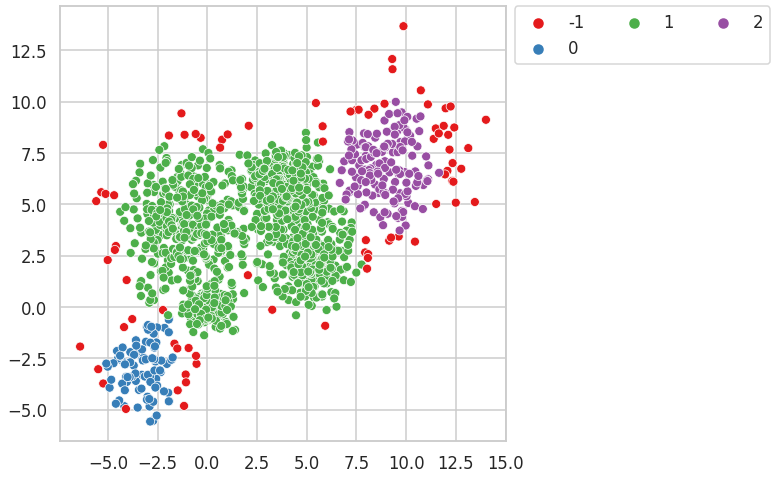

-----------------------------------------------------------------------------------------------------
===============================================================GMM==============================================================================
For 6 clusters, the average silhouette_score is : 0.48567327695888446 with covariance type : tied
2    26.413793
5    20.344828
4    18.482759
0    15.793103
1    12.689655
3     6.275862
dtype: float64


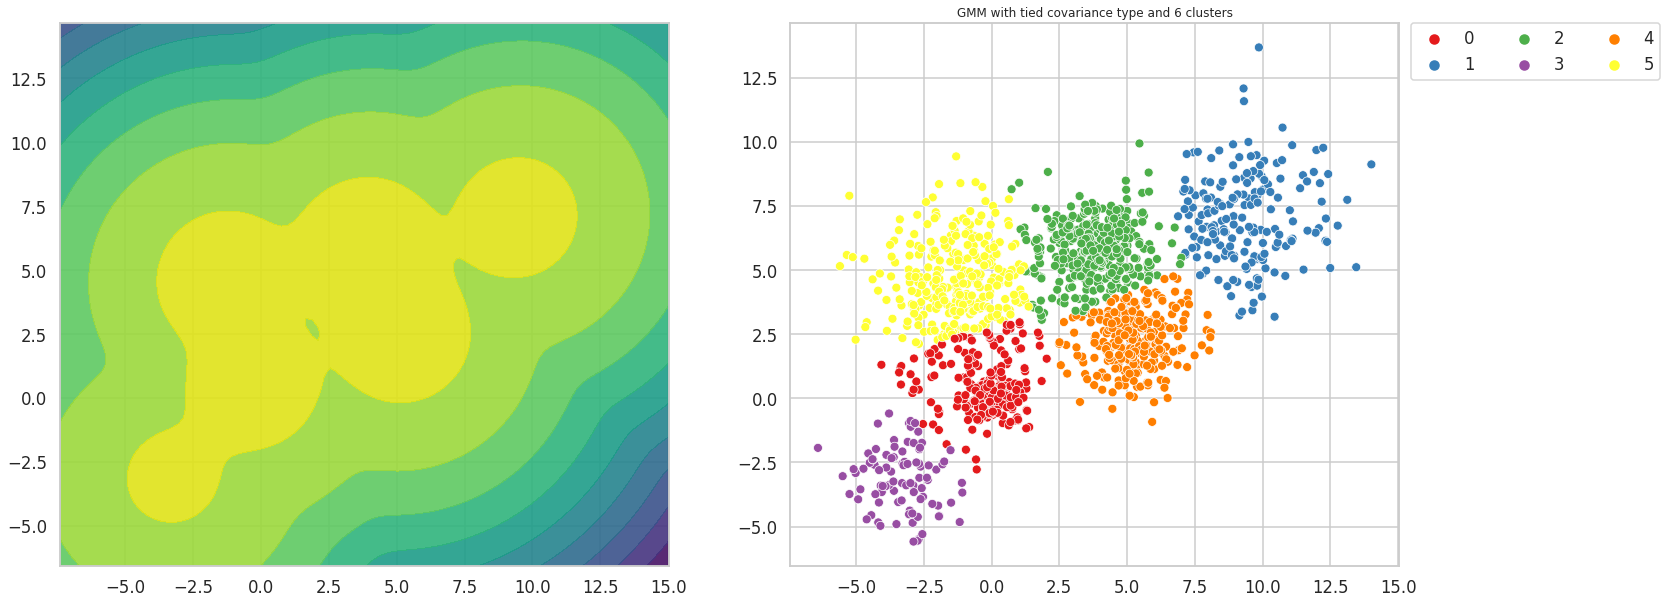

===============================================================Agglomerative_clustering==============================================================================
The number of clusters is : 2 clusters with silhouette score : 0.47
Affinity: manhattan, Linkage: average, Distance Threshold: 10
Silhouette Score: 0.47
1    55.586207
0    44.413793
dtype: float64


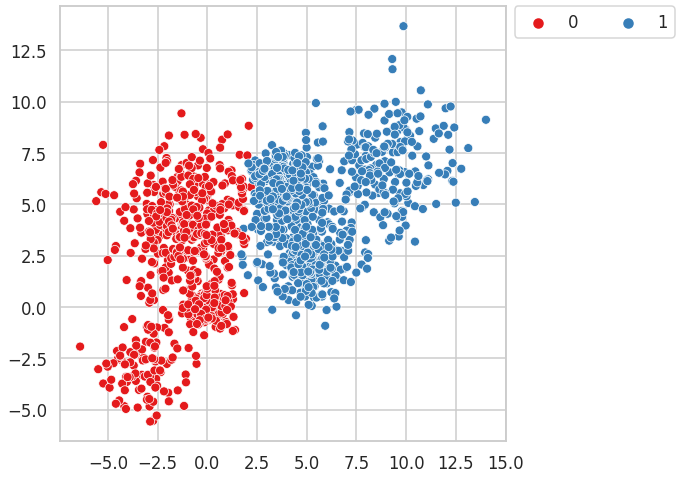

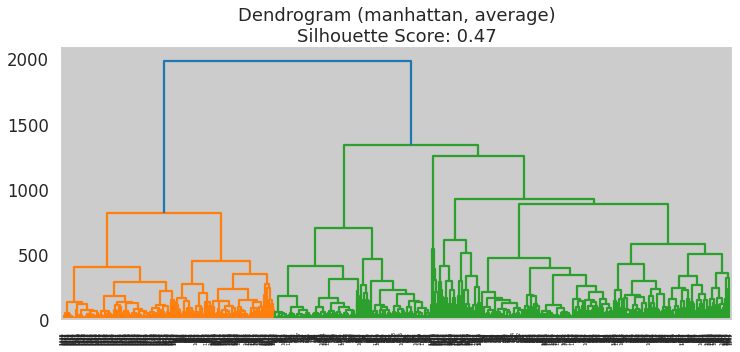

-----------------------------------------------------------------------------------------------------


In [19]:
print("===============================================================K_mean==============================================================================")
Kmean_best_silhouette_score, kmean_n_clusters = K_mean(Multi_blob_Data, min_clusters = 6, max_clusters = 6)
print("===============================================================DBScan==============================================================================")
DBScan_best_silhouette_score, DBScan_best_params = DBScan(Multi_blob_Data,min_eps = 0.8, max_eps = 0.8, min_samples = 10, max_samples = 10)
print("===============================================================GMM==============================================================================")
gmm_best_silhouette_score , gmm_n_clusters, covariance_type = GMM(Multi_blob_Data,min_clusters = 6, max_clusters = 6,covariance_types = ['tied'])
print("===============================================================Agglomerative_clustering==============================================================================")
Agglomerative_best_silhouette_score, Agglomerative_best_params = Agglomerative_clustering(Multi_blob_Data, affinities = ['manhattan'],linkages = ['average'],distance_thresholds = [10],no_dendograms = False)


### **iris data set**

In [20]:
from sklearn.datasets import load_iris
iris_data = load_iris()
iris_data.target[[10, 25, 50]]
#array([0, 0, 1])
list(iris_data.target_names)
['setosa', 'versicolor', 'virginica']

['setosa', 'versicolor', 'virginica']

before scaling

===============================================================K_mean==============================================================================
For 2 clusters, the average silhouette_score is : 0.6810461692117462 , the destortion function is : 0.8555777695266533 ,and inertia is : 152.3479517603579
0    64.666667
1    35.333333
dtype: float64
===============================================================DBScan==============================================================================
Minimum number of samples : 5.00, and epsilon: 0.90 produces 2 clusters with silhouette score : 0.69
The Noise percentage is : 0
1    66.666667
0    33.333333
dtype: float64
-----------------------------------------------------------------------------------------------------
===============================================================GMM==============================================================================
For 2 clusters, the average silhouette_score is : 0.6867350732769777 with covarianc

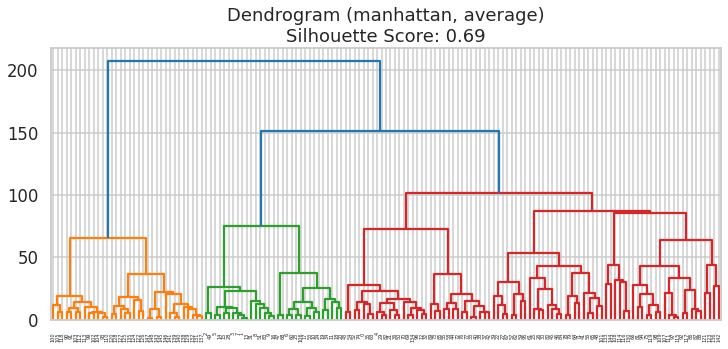

-----------------------------------------------------------------------------------------------------


In [21]:
print("===============================================================K_mean==============================================================================")
Kmean_best_silhouette_score, kmean_n_clusters = K_mean(iris_data.data, min_clusters = 2, max_clusters = 2)
print("===============================================================DBScan==============================================================================")
DBScan_best_silhouette_score, DBScan_best_params = DBScan(iris_data.data,min_eps = 0.9, max_eps = 0.9, min_samples = 5, max_samples = 5)
print("===============================================================GMM==============================================================================")
gmm_best_silhouette_score , gmm_n_clusters, covariance_type = GMM(iris_data.data,min_clusters = 2, max_clusters = 2,covariance_types = ['tied']) # or any other covariance types
print("===============================================================Agglomerative_clustering==============================================================================")
Agglomerative_best_silhouette_score, Agglomerative_best_params = Agglomerative_clustering(iris_data.data, affinities = ['manhattan'],linkages = ['average'],distance_thresholds = [4],no_dendograms = False)

after scaling 

In [22]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(iris_data.data)

===============================================================K_mean==============================================================================
For 2 clusters, the average silhouette_score is : 0.5817500491982808 , the destortion function is : 1.0601245127745642 ,and inertia is : 222.36170496502302
0    66.666667
1    33.333333
dtype: float64
===============================================================DBScan==============================================================================
Minimum number of samples : 25.00, and epsilon: 1.80 produces 2 clusters with silhouette score : 0.58
The Noise percentage is : 0
1    66.666667
0    33.333333
dtype: float64
-----------------------------------------------------------------------------------------------------
===============================================================GMM==============================================================================
For 2 clusters, the average silhouette_score is : 0.5817500491982808 with covaria

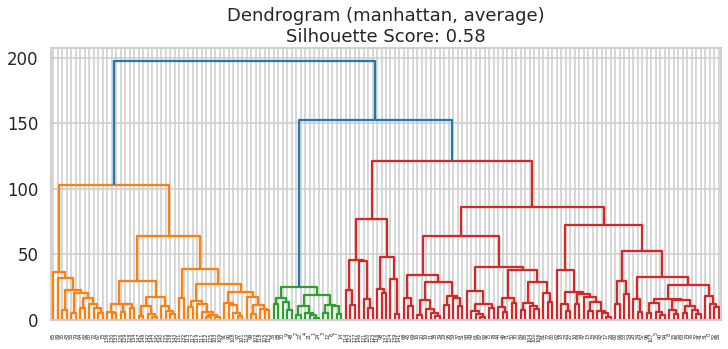

-----------------------------------------------------------------------------------------------------


In [23]:
print("===============================================================K_mean==============================================================================")
Kmean_best_silhouette_score, kmean_n_clusters = K_mean(scaled_data, min_clusters = 2, max_clusters = 2)
print("===============================================================DBScan==============================================================================")
DBScan_best_silhouette_score, DBScan_best_params = DBScan(scaled_data,min_eps = 1.8, max_eps = 1.8, min_samples = 25, max_samples = 25)
print("===============================================================GMM==============================================================================")
gmm_best_silhouette_score , gmm_n_clusters, covariance_type = GMM(scaled_data,min_clusters = 2, max_clusters = 2,covariance_types = ['tied']) # or any other covariance types
print("===============================================================Agglomerative_clustering==============================================================================")
Agglomerative_best_silhouette_score, Agglomerative_best_params = Agglomerative_clustering(scaled_data, affinities = ['manhattan'],linkages = ['average'],distance_thresholds = [5],no_dendograms = False)

Features relations


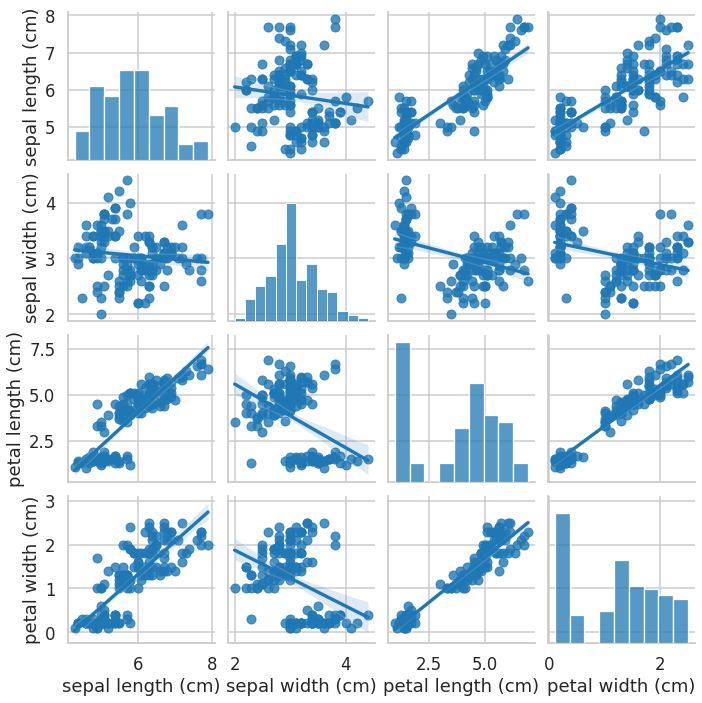

In [24]:
sns.pairplot(pd.DataFrame(iris_data.data,columns = iris_data.feature_names), kind="reg")
plt.show()

pca 3 components 

In [25]:
pca = PCA(n_components=3)
# prepare transform on dataset
pca.fit(iris_data.data)
# apply transform to dataset
transformed = pca.transform(iris_data.data)
data_3d = pd.DataFrame(transformed,columns = ["1",'2',"3"])
df = px.data.iris()
fig = px.scatter_3d(data_3d, x='1', y='2', z='3',
              color='3')
fig.show()

===============================================================K_mean==============================================================================
For 2 clusters, the average silhouette_score is : 0.6869258005156983 , the destortion function is : 0.8377377909845138 ,and inertia is : 148.79893436516977
1    64.666667
0    35.333333
dtype: float64
===============================================================DBScan==============================================================================
Minimum number of samples : 5.00, and epsilon: 0.90 produces 2 clusters with silhouette score : 0.69
The Noise percentage is : 0
1    66.666667
0    33.333333
dtype: float64
-----------------------------------------------------------------------------------------------------
===============================================================GMM==============================================================================
For 2 clusters, the average silhouette_score is : 0.692612946075623 with covarianc

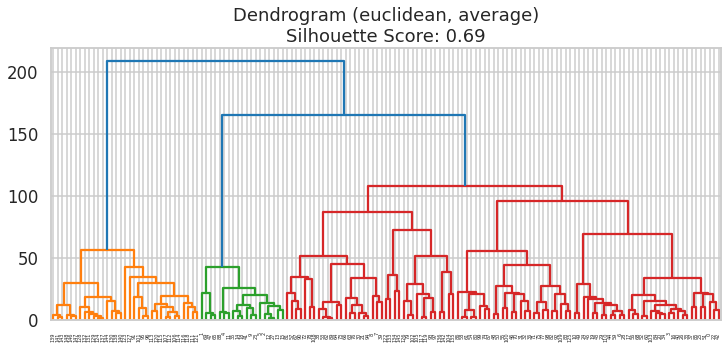

-----------------------------------------------------------------------------------------------------


In [26]:
print("===============================================================K_mean==============================================================================")
Kmean_best_silhouette_score, kmean_n_clusters = K_mean(data_3d, min_clusters = 2, max_clusters = 2)
print("===============================================================DBScan==============================================================================")
DBScan_best_silhouette_score, DBScan_best_params = DBScan(data_3d,min_eps = 0.9, max_eps = 0.9, min_samples = 5, max_samples = 5)
print("===============================================================GMM==============================================================================")
gmm_best_silhouette_score , gmm_n_clusters, covariance_type = GMM(data_3d,min_clusters = 2, max_clusters = 2,covariance_types = ['spherical']) 
print("===============================================================Agglomerative_clustering==============================================================================")
Agglomerative_best_silhouette_score, Agglomerative_best_params = Agglomerative_clustering(data_3d, affinities = ['euclidean'],linkages = ['average'],distance_thresholds = [3],no_dendograms = False)

pca 2 components 

In [27]:
pca = PCA(n_components=2)
# prepare transform on dataset
pca.fit(iris_data.data)
# apply transform to dataset
transformed = pca.transform(iris_data.data)
data_2d = pd.DataFrame(transformed,columns = ["1",'2'])
df = px.data.iris()
fig = px.scatter(data_2d,x = "1",y = "2",
              color='2')
fig.show()

===============================================================K_mean==============================================================================


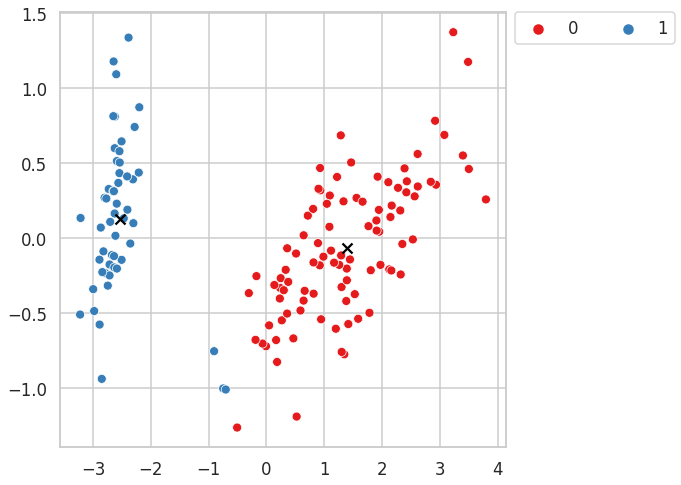

For 2 clusters, the average silhouette_score is : 0.7056703225102109 , the destortion function is : 0.7843727059296363 ,and inertia is : 137.1553011281841
0    64.666667
1    35.333333
dtype: float64
===============================================================DBScan==============================================================================
Minimum number of samples : 6.00, and epsilon: 0.90 produces 2 clusters with silhouette score : 0.71
The Noise percentage is : 0
1    66.666667
0    33.333333
dtype: float64


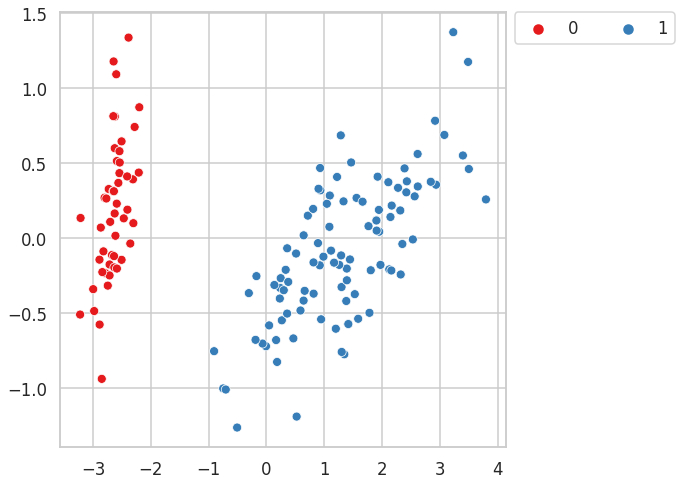

-----------------------------------------------------------------------------------------------------
Minimum number of samples : 23.00, and epsilon: 0.60 produces 3 clusters with silhouette score : 0.57
The Noise percentage is : 0.08666666666666667
 1    58.666667
 0    32.666667
-1     8.666667
dtype: float64


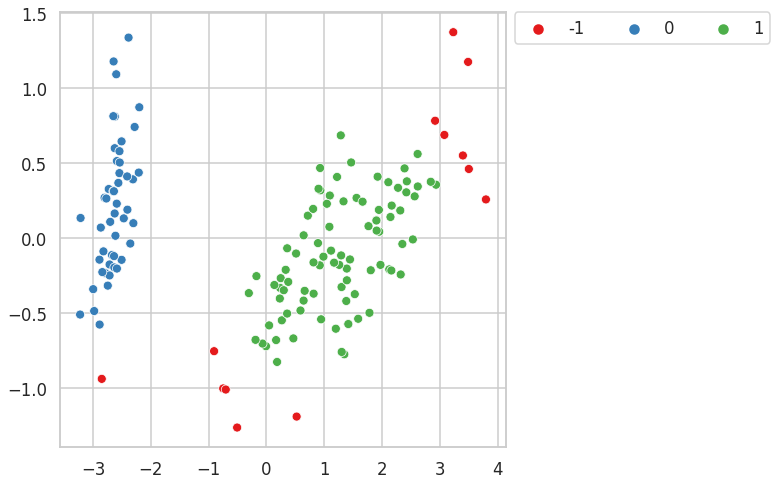

-----------------------------------------------------------------------------------------------------
===============================================================GMM==============================================================================
For 2 clusters, the average silhouette_score is : 0.711235373323721 with covariance type : tied
1    66.666667
0    33.333333
dtype: float64


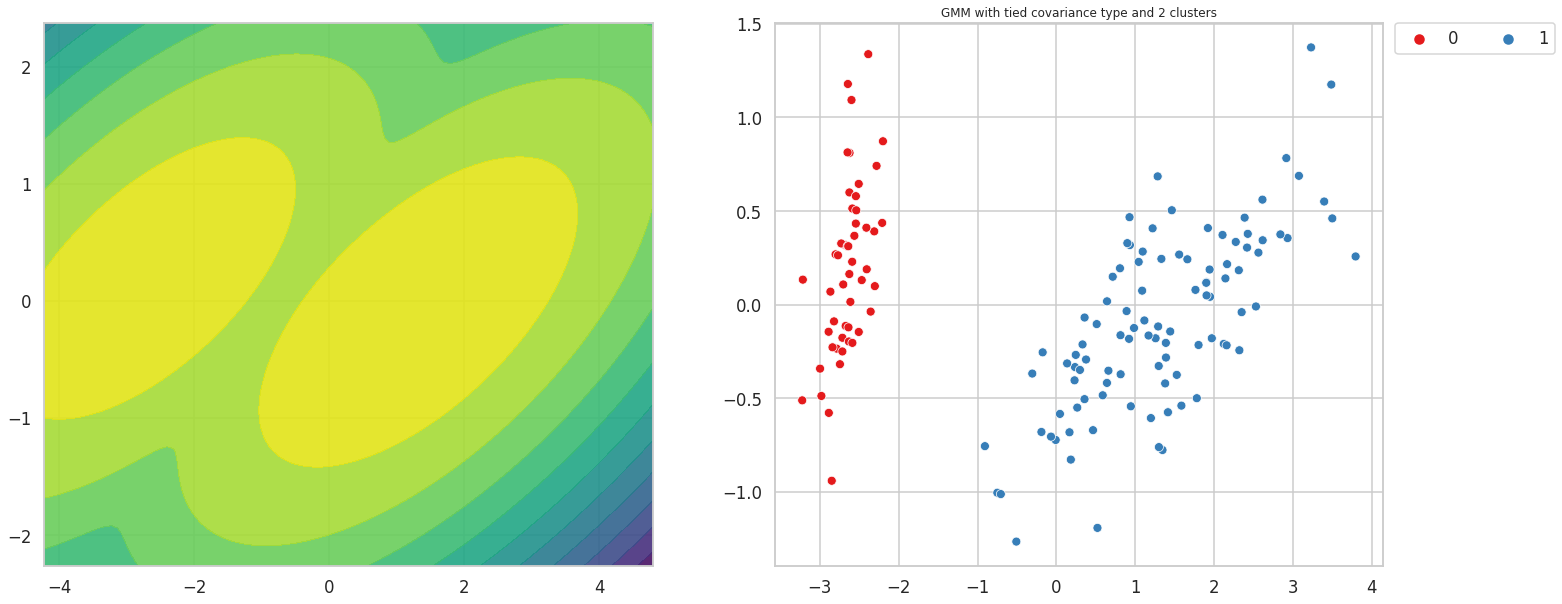

===============================================================Agglomerative_clustering==============================================================================
The number of clusters is : 2 clusters with silhouette score : 0.71
Affinity: euclidean, Linkage: average, Distance Threshold: 3
Silhouette Score: 0.71
0    66.666667
1    33.333333
dtype: float64


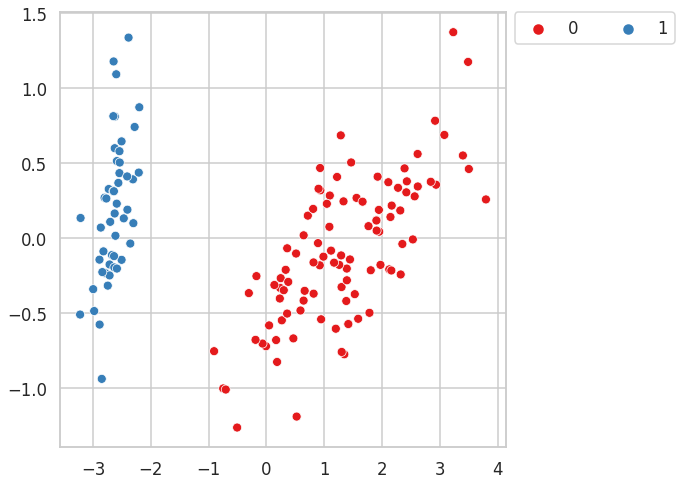

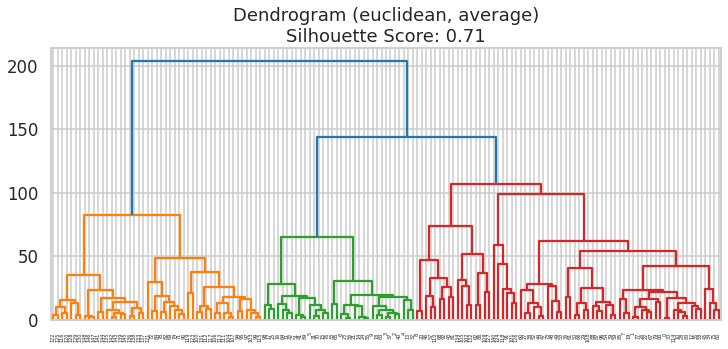

-----------------------------------------------------------------------------------------------------


In [30]:
print("===============================================================K_mean==============================================================================")
Kmean_best_silhouette_score, kmean_n_clusters = K_mean(data_2d.values, min_clusters = 2, max_clusters = 2)
print("===============================================================DBScan==============================================================================")
DBScan_best_silhouette_score, DBScan_best_params = DBScan(data_2d.values,min_eps = 0.9, max_eps = 0.9, min_samples = 6, max_samples = 6)
# How ever we may assume that we have noise from the plot and cluster them into separate cluster as a noise as they are a way from the data  
DBScan_best_silhouette_score, DBScan_best_params = DBScan(data_2d.values,min_eps = 0.6, max_eps = 0.6, min_samples = 23, max_samples = 23)
print("===============================================================GMM==============================================================================")
gmm_best_silhouette_score , gmm_n_clusters, covariance_type = GMM(data_2d.values,min_clusters = 2, max_clusters = 2,covariance_types = ['tied']) # or any other covariance types
print("===============================================================Agglomerative_clustering==============================================================================")
Agglomerative_best_silhouette_score, Agglomerative_best_params = Agglomerative_clustering(data_2d.values, affinities = ['euclidean'],linkages = ['average'],distance_thresholds = [3],no_dendograms = False)

## **Customer dataset**

In [34]:
df_Customer = pd.read_csv("/content/Customer data.csv",index_col = "ID")

In [35]:
df_Customer.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [36]:
df_Customer.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [37]:
df_Customer.nunique()

Sex                   2
Marital status        2
Age                  58
Education             4
Income             1982
Occupation            3
Settlement size       3
dtype: int64

In [38]:
scaler = StandardScaler()
# Fit and transform the data using the scaler
scaled_data = scaler.fit_transform(df_Customer)

===============================================================K_mean==============================================================================
For 4 clusters, the average silhouette_score is : 0.26879180394522123 , the destortion function is : 1.7893352543407437 ,and inertia is : 7169.87082246584
0    35.25
1    28.50
3    23.10
2    13.15
dtype: float64
For 5 clusters, the average silhouette_score is : 0.2611715467897347 , the destortion function is : 1.6746684651213661 ,and inertia is : 6407.301360998375
3    26.05
4    24.40
1    22.70
0    14.35
2    12.50
dtype: float64
===============================================================DBScan==============================================================================
Minimum number of samples : 5.00, and epsilon: 1.40 produces 29 clusters with silhouette score : 0.36845
The Noise percentage is : 0.0205
1    17.90
3    13.40
7     9.25
8     7.95
2     6.25
dtype: float64
21    0.55
22    0.45
27    0.45
18    0.35
20    0.25
dt

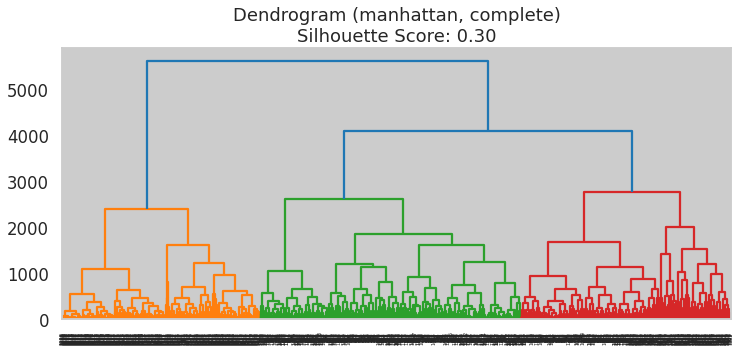

-----------------------------------------------------------------------------------------------------


In [39]:
print("===============================================================K_mean==============================================================================")
Kmean_best_silhouette_score, kmean_n_clusters = K_mean(scaled_data, min_clusters = 4, max_clusters = 4)
# 4 or 5 as the change in the distortion and ineria became very slow and also the mimimum cluster size is grater than 10% while 4 has higher silhouette_score than 5
Kmean_best_silhouette_score, kmean_n_clusters = K_mean(scaled_data, min_clusters = 5, max_clusters = 5)
print("===============================================================DBScan==============================================================================")
DBScan_best_silhouette_score, DBScan_best_params = DBScan(scaled_data,min_eps = 1.4, max_eps = 1.4, min_samples = 5, max_samples = 5)
# however there are many clusters 
DBScan_best_silhouette_score, DBScan_best_params = DBScan(scaled_data,min_eps = 2, max_eps = 2, min_samples = 23, max_samples = 23)
print("===============================================================GMM==============================================================================")
gmm_best_silhouette_score , gmm_n_clusters, covariance_type = GMM(scaled_data,min_clusters = 2, max_clusters = 2,covariance_types = ['full']) # or tied
print("===============================================================Agglomerative_clustering==============================================================================")
Agglomerative_best_silhouette_score, Agglomerative_best_params = Agglomerative_clustering(scaled_data, affinities = ['manhattan'],linkages = ['complete'],distance_thresholds = [9],no_dendograms = False)